## Neural Part Of Speech Tagging

We're now going to solve the same problem of POS tagging with neural networks.
<img src=https://i.stack.imgur.com/6pdIT.png width=320>

From deep learning perspective, this is a task of predicting a sequence of outputs aligned to a sequence of inputs. There are several problems that match this formulation:
* Part Of Speech Tagging -  an auxuliary task for many NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

In [ ]:
%tensorflow_version 1.x

ValueError: ignored

In [1]:
import nltk
import sys
import numpy as np

nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
<ipython-input-1-bc9847c14597>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])


In [2]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.25,random_state=42)

In [3]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    
draw(data[11])
draw(data[10])
draw(data[7])

NOUN,ADP,NOUN,NOUN,NOUN,NOUN,VERB,ADV,VERB,ADP,DET,ADJ,NOUN,.,implementation,of,georgia's,automobile,title,law,was,also,recommended,by,the,outgoing,jury,.


PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [4]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#'] + list(list(zip(*word_counts.most_common(10000)))[0])

#let's measure what fraction of data words are in the dictionary
print("Coverage = %.5f" % (float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values())))

Coverage = 0.92876


In [5]:
from collections import defaultdict
word_to_id = defaultdict(lambda:1, { word: i for i, word in enumerate(all_words) })
tag_to_id = { tag: i for i, tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix

In [6]:
def to_matrix(lines, token_to_id, max_len=None, pad=0, dtype='int32', time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix



In [7]:
batch_words, batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

print("Word ids:")
print(to_matrix(batch_words, word_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[   2 3057    5    2 2238 1334 4238 2454    3    6   19   26 1070   69
     8 2088    6    3    1    3  266   65  342    2    1    3    2  315
     1    9   87  216 3322   69 1558    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  45   12    8  511 8419    6   60 3246   39    2    1    1    3    2
   845    1    3    1    3   10 9910    2    1 3470    9   43    1    1
     3    6    2 1046  385   73 4562    3    9    2    1    1 3250    3
    12   10    2  861 5240   12    8 8936  121    1    4]
 [  33   64   26   12  445    7 7346    9    8 3337    3    1 2811    3
     2  463  572    2    1    1 1649   12    1    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Tag ids:
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0

### Build model

Unlike our previous lab, this time we'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [8]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [9]:
from keras.utils.np_utils import to_categorical
BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
    assert isinstance(sentences,np.ndarray),"Make sure sentences is q numpy array"
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_words,batch_tags = [],[]
            for sent in sentences[batch_indices]:
                words,tags = zip(*sent)
                batch_words.append(words)
                batch_tags.append(tags)

            batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
            batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

            batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            yield batch_words,batch_tags_1hot
        

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [10]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n"%acc)
        sys.stdout.flush()
        

In [11]:
model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

<ipython-input-11-e75a6e7fae6a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


Epoch 1/5
1344/1343 [==============================] - ETA: 0s - loss: 0.2346
Measuring validation accuracy...
448/448 [==============================] - 14s 31ms/step

Validation accuracy: 0.94126

1343/1343 [==============================] - 157s 109ms/step - loss: 0.2346
Epoch 2/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0575
Measuring validation accuracy...
448/448 [==============================] - 8s 18ms/step

Validation accuracy: 0.94451

1343/1343 [==============================] - 103s 77ms/step - loss: 0.0575
Epoch 3/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0512
Measuring validation accuracy...
448/448 [==============================] - 8s 17ms/step

Validation accuracy: 0.94600

1343/1343 [==============================] - 104s 77ms/step - loss: 0.0512
Epoch 4/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0472
Measuring validation accuracy...
448/448 [==============================] - 7s 17ms/step

Validation 

Measure final accuracy on the whole test set.

In [ ]:
acc = compute_test_accuracy(model)
print("Final accuracy: %.5f"%acc)

assert acc>0.94, "Keras has gone on a rampage again, please contact course staff."

448/448 [==============================] - 7s 16ms/step
Final accuracy: 0.94551


### Going bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN now and LSTM/GRU later) and it actually creates two layers under the hood.

Your first task is to use such a layer our POS-tagger.

In [ ]:
#Define a model that utilizes bidirectional SimpleRNN
model = keras.models.Sequential()
#<Your code here!>

model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64, return_sequences=True)))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)


In [ ]:
model.compile('adam','categorical_crossentropy')

model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5


<ipython-input-22-e75a6e7fae6a>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


1344/1343 [==============================] - ETA: 0s - loss: 0.1910
Measuring validation accuracy...
448/448 [==============================] - 15s 32ms/step

Validation accuracy: 0.95521

1343/1343 [==============================] - 250s 184ms/step - loss: 0.1910
Epoch 2/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0427
Measuring validation accuracy...
448/448 [==============================] - 13s 30ms/step

Validation accuracy: 0.96031

1343/1343 [==============================] - 161s 120ms/step - loss: 0.0427
Epoch 3/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0349
Measuring validation accuracy...
448/448 [==============================] - 14s 31ms/step

Validation accuracy: 0.96325

1343/1343 [==============================] - 159s 118ms/step - loss: 0.0349
Epoch 4/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0297
Measuring validation accuracy...
448/448 [==============================] - 13s 28ms/step

Validation accur

In [ ]:
acc = compute_test_accuracy(model)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

448/448 [==============================] - 13s 29ms/step

Final accuracy: 0.96194
Well done!


**Task** I: Structured loss functions (more bonus points)

Since we're tagging the whole sequence at once, we might as well train our network to do so. Remember linear CRF from the lecture? You can also use it as a loss function for your RNN


  * There's more than one way to do so, but we'd recommend starting with [Conditional Random Fields](http://blog.echen.me/2012/01/03/introduction-to-conditional-random-fields/)
  * You can plug CRF as a loss function and still train by backprop. There's even some neat tensorflow [implementation](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/CRF) for you.
  * Alternatively, you can condition your model on previous tags (make it autoregressive) and perform __beam search__ over that model.

In [12]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-2j1pdklq
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-2j1pdklq
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101078 sha256=d4b39a495b5f0a042d4c5046e0b3315300fb7ec6e618be23bf9660e1bf11d26d
  Stored in directory: /tmp/pip-ephem-wheel-cache-vcpzyqam/wheels/83/b3/99/125cd08d3e8224b434b1b4badd6f8b2651e0251b7e8f983e60
Successfully built keras-contrib


In [ ]:
!pip install q tensorflow==2.2
!pip install q keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.2 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached q-2.7-py2.py3-none-any.whl (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from keras_contrib.layers import CRF

model = keras.models.Sequential()

model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.Bidirectional(L.SimpleRNN(64, return_sequences=True)))

stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)
model.add(CRF(64))

model.compile('adam', loss=crf_loss, metrics=[crf_accuracy])

In [14]:
model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5)

Epoch 1/5


<ipython-input-14-ffd7a726874d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generate_batches(train_data),len(train_data)/BATCH_SIZE,


AttributeError: ignored

Устанавливать более старые версии tf и keras Google colab не очень хочет. Поэтому последнюю модель прогонял в PyCharm. 

В интернете нашел информацию что crf_loss нельзя использовать, если последний слой в модели не CRF. Это так или есть какие-то обходные пути для этого?

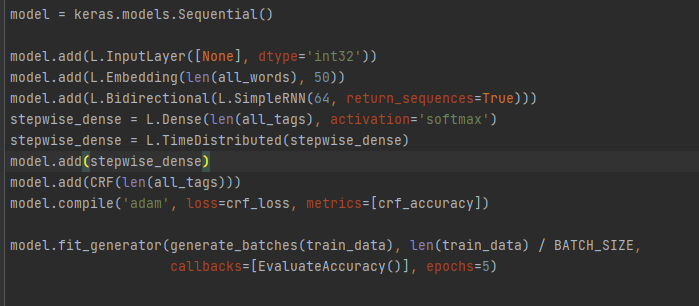

Статистика accuracy по эпохам:

Validation accuracy: 0.49249

Validation accuracy: 0.57070

Validation accuracy: 0.69640

Validation accuracy: 0.83554

Validation accuracy: 0.89381

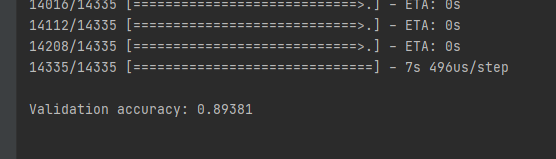


#### Some tips
Here there are a few more tips on how to improve training that are a bit trickier to impliment. We strongly suggest that you try them _after_ you've got a good initial model.
* __Use pre-trained embeddings__: you can use pre-trained weights from [there](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) to kickstart your Embedding layer.
  * Embedding layer has a matrix W (layer.W) which contains word embeddings for each word in the dictionary. You can just overwrite them with tf.assign.
  * When using pre-trained embeddings, pay attention to the fact that model's dictionary is different from your own.
  * You may want to switch trainable=False for embedding layer in first few epochs as in regular fine-tuning.  
* __Go beyond SimpleRNN__: there's `keras.layers.LSTM` and `keras.layers.GRU`
  * If you want to use a custom recurrent Cell, read [this](https://keras.io/layers/recurrent/#rnn)
  * You can also use 1D Convolutions (`keras.layers.Conv1D`). They are often as good as recurrent layers but with less overfitting.
* __Stack more layers__: if there is a common motif to this course it's about stacking layers
  * You can just add recurrent and 1dconv layers on top of one another and keras will understand it
  * Just remember that bigger networks may need more epochs to train
* __Regularization__: you can apply dropouts as usual but also in an RNN-specific way
  * `keras.layers.Dropout` works inbetween RNN layers
  * Recurrent layers also have `recurrent_dropout` parameter
* __Gradient clipping__: If your training isn't as stable as you'd like, set `clipnorm` in your optimizer.
  * Which is to say, it's a good idea to watch over your loss curve at each minibatch. Try tensorboard callback or something similar.
* __Word Dropout__: tl;dr randomly replace words with UNK during training. 
  * This can also simulate increased amount of unknown words in the test set
* __Larger vocabulary__: You can obtain greater performance by expanding your model's input dictionary from 5000 to up to every single word!
  * Just make sure your model doesn't overfit due to so many parameters.
  * Combined with regularizers or pre-trained word-vectors this could be really good cuz right now our model is blind to >5% of words.  
* __More efficient batching__: right now TF spends a lot of time iterating over "0"s
  * This happens because batch is always padded to the length of a longest sentence
  * You can speed things up by pre-generating batches of similar lengths and feeding it with randomly chosen pre-generated batch.
  * This technically breaks the i.i.d. assumption, but it works unless you come up with some insane rnn architectures.
* __The most important advice__: don't cram in everything at once!
  * If you stuff in a lot of modiffications, some of them almost inevitably gonna be detrimental and you'll never know which of them are.
  * Try to instead go in small iterations and record experiment results to guide further search.
    
Good hunting!

Обязательно попробую спасибо)

### Вопросы:

1. В лекции говорилось что RNN хорошо себя показывает в состовлении описаний для картинок. А если задача стоит в том чтобы определить тип изображения из, например, 100 возможных. То для этих целей лучше использовать чистый CNN или комбинацию CNN и RNN? Или для этих целей нужен совершенно другой подход?